# Geometric factor calculations using Monte Carlo simulation data 
By Andrei R. Hanu - <andrei.hanu@nasa.gov>

## Introduction

The geometric factor ($\bf{G}$, units of cm$^2$ sr) of a particle detector is analogous to the "collecting power" of an optical telescope and is a function of the surface area of the instrument and detection efficiency, which itself is a function of the charge, mass, and energy of the incident particles. If the detector's geometry factor is known, the spatial differential flux ($\bf{\Phi}$, units of particles cm$^{-2}$ sr$^{-1}$ sec$^{-1}$) incident on the detector can be calculated from the counting rate ($\bf{N_D}$, units of particles $sec^{-1}$). So very simply, the geometric factor is defined as the counts received by a detector per unit time divided by the spatial differential flux around the instrument.

$$ G = \frac{N_D}{J} $$

** Note: For radiation risk assesment calculations, the flux is typically measured in energy bins with units of particles cm$^{-2}$ sr$^{-1}$ sec$^{-1}$ MeV$^{-1}$ **

Tradiationally, a detector's geometric factor has usually been estimated by approximation, however, only a few analytical solutions exist for simple source and detector geometries - see Sullivan (1971). For more complicated detector geometries, including electronic coincidence/anti-coincidence logic, an analytical solution might be difficult, or even impossible, to derive in the closed form. In such cases, the Monte Carlo technique is employed to compute the geometrical factor, see Crannell et al. (1971), by surrounded the detector geometry with a spherical source and assuming an isotropic radiation environment. Although, you can also apply this technique to anisotropic radiation environments. 

## Isotropic Radiation



## Source Normalization

For isotropic radiation environments, the number of particles $\bf{N_R}$ traversing a sphere is determined by the integrating the spatial differential flux over the surface area of the sphere and solid angle.

$$ N_R = \int_{\Omega}\int_{S} JdSd\Omega $$

Where the differential surface area ($\bf{dS}$) and differential solid angle ($\bf{d\Omega}$) in spherical coordinates is:

$$ dS = R^2 sin \theta d\theta d\phi $$

$$ d\Omega = sin \theta d\theta d\phi $$

Working through the integral, we see that the number of particles $\bf{N_R}$ traversing a sphere is:

$$ N_R = 4 \pi^2 R^2 J $$

And it depends on:

- The radius (ie. bigger sphere == more particles crossing the sphere)
- The spatial differential flux (ie. more flux == more particles crossing the sphere)

Finally, by using Eq.1 and Eq. 5 the geometric factor for an isotropic radiation environments can be written as follows:

$$ G = \frac{N_D}{N_R}4 \pi^2 R^2 $$

Where:

- $N_D$ is the number of particles interacting with the detector model
- $N_R$ is the total number of simulated particles
- $R$ is the radius of the spherical source encircling the detector model

The associated standard deviation ($\bf{\sigma_G}$) is obtained from the binomial distribution and follows:

$$ \sigma_G = 4\pi^2R^2 \sqrt{\left(1-\frac{N_D}{N_R}\right)\frac{N_D}{N_R^2}} $$

## Monte Carlo method

To calculate the geometric factor of a detector using the Monte Carlo method, the following steps need to be taken:

- The detector geometry, or a simplified model, should be implemented in your favourite Monte Carlo particle transport  code (Geant4, MCNP, FLUKA, EGS, etc)

If an isotropic flux, typical of space-borne instruments, is assumed:

- The detector geometry is enveloped by a spherical source such that the spectral, spatial, and angular distribution of primary particles can be specified

- The primary particles must be uniformly distributed over the entire surface of spherical source
- The angular distribution for the emission of primary particles must follow a cosine-law distribution

## References

+ Sullivan, J. D. "Geometric factor and directional response of single and multi-element particle telescopes." Nuclear Instruments and methods 95.1 (1971): 5-11.

+ Crannell, C. J., and J. F. Ormes. "Geometrical-factor determination using a monte carlo approach." Nuclear Instruments and Methods 94.1 (1971): 179-183.

+ Sanderson, T. R., and D. E. Page. "Geometrical aspects of the performance of cosmic ray detector telescopes in non-isotropic particle distributions." Nuclear Instruments and Methods 104.3 (1972): 493-504.


In [21]:
# Matplotlib - 2D plotting library
from matplotlib import pyplot as plt
from matplotlib import rcParams

# Show matplotlib figures inline the notebook
%matplotlib inline

# Pandas - High-performance data analysis
import pandas

# Glob - Unix style pathname pattern expansion
# Used to aggregate folders and files into a single list so they can be iterated over
import glob

# Numpy - For handling of large, multi-dimensional arrays and matrices
import numpy as np
from numpy.linalg import solve

# Scipy - For accurate integration
from scipy.integrate import simps
from scipy.integrate import trapz
from scipy.optimize import curve_fit
import scipy.odr as sc

##########################################################################################
# Setting rcParams for publication quality graphs
fig_width_pt = 246.0                    # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27               # Convert pt to inch
golden_mean = (np.sqrt(5)-1.0)/2.0      # Aesthetic ratio
fig_width = fig_width_pt*inches_per_pt  # Width in inches
fig_height = fig_width*golden_mean      # Height in inches
fig_size =  [fig_width, fig_height]
# fig_size =  [fig_height,fig_width]
fig_size =  [7.3,4.2]
# fig_size =  [4.2,7.3]
# fig_size =  [7.3*1.5,4.2*1.5]
# fig_size =  [7.3*2,4.2*2]
params = {'backend': 'pdf',
        'axes.labelsize': 11,
        'legend.fontsize': 9,
        'xtick.labelsize': 10,
        'ytick.labelsize': 10,
        'xtick.major.size': 6,
        'xtick.major.width': 1,
        'xtick.minor.size': 2.5,
        'xtick.minor.width': 1,
        'ytick.major.size': 6,
        'ytick.major.width': 1,
        'ytick.minor.size': 2.5,
        'ytick.minor.width': 1,
        'font.family': 'times-new-roman',
        'font.sans-serif': 'Times New Roman',
        'font.size': 10,
        'text.usetex': True,
        'figure.figsize': fig_size}

# Update rcParams
rcParams.update(params)

In [2]:
##########################################################################################
# Energy of incident (input) particles
InputEnergies = np.array([np.linspace(10,90, num=9, endpoint=True, dtype = int),
                          np.linspace(100,900, num=9, endpoint=True, dtype = int),
                          np.linspace(1100,1900, num=9, endpoint=True, dtype = int),
                          np.linspace(1000,9000, num=9, endpoint=True, dtype = int),
                          np.linspace(10000,90000, num=9, endpoint=True, dtype = int),
                          np.linspace(100000,900000, num=9, endpoint=True, dtype = int),
                            ]).flatten()

# Arrange the array into the proper order
# InputEnergies = np.delete(InputEnergies,18)
# InputEnergies = np.insert(InputEnergies, [9], [1000])
# InputEnergies = np.insert(InputEnergies, [45], [1000000])
InputEnergies = np.delete(InputEnergies,27)
InputEnergies = np.insert(InputEnergies, [18], [1000])
InputEnergies = np.insert(InputEnergies, [54], [1000000])
# ##########################################################################################
# Energy thresholds (in eV) for events that will be included in the analysis
Thr_Gas = 100.
print InputEnergies

[    100     200     300     400     500     600     700     800     900
    1000    1100    1200    1300    1400    1500    1600    1700    1800
    1900    2000    3000    4000    5000    6000    7000    8000    9000
   10000   20000   30000   40000   50000   60000   70000   80000   90000
  100000  200000  300000  400000  500000  600000  700000  800000  900000
 1000000]


In [6]:
##########################################################################################
# Import Data for use by the program.
# This data is generated by the file G4AdEPTCubeSat-DataProcessing

GammaData = '../G4AdEPTCubeSat_Results/Ar+CS2/Gamma_Data/gamma_Data.csv'
DataFolder = '../G4AdEPTCubeSat_Results/Ar+CS2/Gammas/'
Data = pandas.read_csv(GammaData, usecols=[1,2,3,4,5,6,7,8,9,10,11,12,13], comment="#", error_bad_lines=False, skip_blank_lines=True).values
# Columns for np array Data
# Column 0: Incident photon energy
# Column 1: Number of Positrons which deposited energy
# Column 2: Number of Electrons which deposited energy
# Column 3: Number of Positron energy depositions below threshold
# Column 4: Number of Electron energy depositions below threshold
# Column 5: Number of total events which deposited energy above threshold
# Column 6: Number of total events below threshold
# Column 7: Number of Compton Scattering events
# Column 8: Number of Pair Production events
# Column 9: Number of Photoelectric events
# Column 10: Number of Triton creation events

In [17]:
##########################################################################################
# Calculate the geometry factor (G) assuming an isotropic radiation environment.
# The detector is centered on, and encircled by, a spherical source of radius (R) and
# with N_R simulated particles distributed uniformly along the inner surface.
# Everything with the suffix _2 is from the group which had 1 000 000 000 photons

# Source information (Get this from the Geant4 simulation!!)
# Energies 1.1 - 1.9 MeV have 1 000 000 000 photons simulated
N_R = 100000000.
# N_R_2 = 100000000.
N_R_2 = 1000000000.
R = 10.


# # Calculate the geometry factors
# G_Pair_1 = Data[0:10,8]/N_R*4*(np.pi**2)*(R**2)
# G_Total_1 = Data[0:10,5]/N_R*4*(np.pi**2)*(R**2)

# G_Pair_2 = Data[10:19,8]/N_R_2*4*(np.pi**2)*(R**2)
# G_Total_2 = Data[10:19,5]/N_R_2*4*(np.pi**2)*(R**2)

# G_Pair_3 = Data[19:,8]/N_R*4*(np.pi**2)*(R**2)
# G_Total_3 = Data[19:,5]/N_R*4*(np.pi**2)*(R**2)

# G_Pair = np.ndarray([])
# G_Pair_temp = np.ndarray([])
# G_Pair_temp = np.append(G_Pair_1,G_Pair_2)
# G_Pair = np.append(G_Pair_temp,G_Pair_3)

# G_Total = np.ndarray([])
# G_Total_temp = np.ndarray([])
# G_Total_temp = np.append(G_Total_1,G_Total_2)
# G_Total = np.append(G_Total_temp,G_Total_3)

# # Calculate the errors for geometry factors 
# err_G_Pair_1 = 4*(np.pi**2)*(R**2)*np.sqrt((1-Data[0:10,8]/N_R)*Data[0:10,8]/N_R**2)
# err_G_Total_1 = 4*(np.pi**2)*(R**2)*np.sqrt((1-Data[0:10,5]/N_R)*Data[0:10,5]/N_R**2)

# err_G_Pair_2 = 4*(np.pi**2)*(R**2)*np.sqrt((1-Data[10:19,8]/N_R_2)*Data[10:19,8]/N_R_2**2)
# err_G_Total_2 = 4*(np.pi**2)*(R**2)*np.sqrt((1-Data[10:19,5]/N_R_2)*Data[10:19,5]/N_R_2**2)

# err_G_Pair_3 = 4*(np.pi**2)*(R**2)*np.sqrt((1-Data[19:,8]/N_R)*Data[19:,8]/N_R**2)
# err_G_Total_3 = 4*(np.pi**2)*(R**2)*np.sqrt((1-Data[19:,5]/N_R)*Data[19:,5]/N_R**2)


# err_G_Pair = np.array([])
# err_G_Pair_temp = np.array([])
# err_G_Pair_temp = np.append(err_G_Pair_1,err_G_Pair_2)
# err_G_Pair = np.append(err_G_Pair_temp,err_G_Pair_3)

# err_G_Total = np.array([])
# err_G_Total_temp = np.array([])
# err_G_Total_temp = np.append(err_G_Pair_1,err_G_Pair_2)
# err_G_Total = np.append(err_G_Total_temp,err_G_Total_3)

# # Calculate relative errors for the geometry factors
# relErr_G_Total = err_G_Total/G_Total
# relErr_G_Pair = err_G_Pair/G_Pair


# Calculate the geometry factors
G_Pair_1 = Data[0:19,8]/N_R*4*(np.pi**2)*(R**2)
G_Total_1 = Data[0:19,5]/N_R*4*(np.pi**2)*(R**2)

G_Pair_2 = Data[19:28,8]/N_R_2*4*(np.pi**2)*(R**2)
G_Total_2 = Data[19:28,5]/N_R_2*4*(np.pi**2)*(R**2)

G_Pair_3 = Data[28:,8]/N_R*4*(np.pi**2)*(R**2)
G_Total_3 = Data[28:,5]/N_R*4*(np.pi**2)*(R**2)

G_Pair = np.ndarray([])
G_Pair_temp = np.ndarray([])
G_Pair_temp = np.append(G_Pair_1,G_Pair_2)
G_Pair = np.append(G_Pair_temp,G_Pair_3)

G_Total = np.ndarray([])
G_Total_temp = np.ndarray([])
G_Total_temp = np.append(G_Total_1,G_Total_2)
G_Total = np.append(G_Total_temp,G_Total_3)

# Calculate the errors for geometry factors 
err_G_Pair_1 = 4*(np.pi**2)*(R**2)*np.sqrt((1-Data[0:19,8]/N_R)*Data[0:19,8]/N_R**2)
err_G_Total_1 = 4*(np.pi**2)*(R**2)*np.sqrt((1-Data[0:19,5]/N_R)*Data[0:19,5]/N_R**2)

err_G_Pair_2 = 4*(np.pi**2)*(R**2)*np.sqrt((1-Data[19:28,8]/N_R_2)*Data[19:28,8]/N_R_2**2)
err_G_Total_2 = 4*(np.pi**2)*(R**2)*np.sqrt((1-Data[19:28,5]/N_R_2)*Data[19:28,5]/N_R_2**2)

err_G_Pair_3 = 4*(np.pi**2)*(R**2)*np.sqrt((1-Data[28:,8]/N_R)*Data[28:,8]/N_R**2)
err_G_Total_3 = 4*(np.pi**2)*(R**2)*np.sqrt((1-Data[28:,5]/N_R)*Data[28:,5]/N_R**2)

err_G_Pair = np.array([])
err_G_Pair_temp = np.array([])
err_G_Pair_temp = np.append(err_G_Pair_1,err_G_Pair_2)
err_G_Pair = np.append(err_G_Pair_temp,err_G_Pair_3)

err_G_Total = np.array([])
err_G_Total_temp = np.array([])
err_G_Total_temp = np.append(err_G_Pair_1,err_G_Pair_2)
err_G_Total = np.append(err_G_Total_temp,err_G_Total_3)

# Calculate relative errors for the geometry factors
relErr_G_Total = err_G_Total/G_Total
relErr_G_Pair = err_G_Pair/G_Pair

# Calculate average errors
avgErr100 = np.mean(G_Pair[36:])*np.sqrt(sum((relErr_G_Pair[36:])**2))
avgErr5 = np.mean(G_Pair[22:])*np.sqrt(sum((relErr_G_Pair[22:])**2))
avgErr = np.mean(G_Pair[19:])*np.sqrt(sum((relErr_G_Pair[19:])**2))

# Print results
print InputEnergies[36], InputEnergies[22]
print "Average G above 100 MeV:",np.mean(G_Pair[36:]),"+/-",avgErr100
print "Average G above 5 MeV:",np.mean(G_Pair[22:]),"+/-",avgErr5
print "Total average G:",np.mean(G_Pair[:]),"+/-",avgErr

100000 5000
Average G above 100 MeV: 0.567487708382 +/- 0.0217872982049
Average G above 5 MeV: 0.355753778663 +/- 0.036724253447
Total average G: 0.213495119226 +/- 0.0613607250054


Plot saved to: ../G4AdEPTCubeSat_Results/Ar+CS2/Gammas/Geometric_Factor_Gamma.pdf
0.741996858874


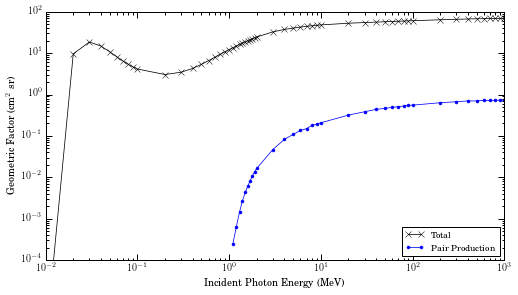

In [18]:
##########################################################################################
# Plot the Geometry Factor over a range of particle energies
G_Total[0]= 1e-6

figG, axG = plt.subplots(1,1)

plt.loglog(Data[:,0]/1000., G_Total, 'kx-', linewidth=0.75, label="Total")
plt.loglog(Data[:,0]/1000., G_Pair, 'b.-', linewidth=0.75, label="Pair Production")

# Figure Properties
axG.set_ylabel(r'Geometric Factor (cm$^2$ sr)')  
axG.set_xlabel('Incident Photon Energy (MeV)') 
axG.set_ylim(1e-4, 1e2)
axG.set_xlim(1e-2, 1000)

axG.legend(loc='lower right')

# Tight Layout
plt.tight_layout()

# Save the figure 
file_figG = 'Geometric_Factor_Gamma.pdf'
plt.savefig(DataFolder + file_figG, bbox_inches="tight")
print 'Plot saved to: ' + (DataFolder+file_figG)


print max(G_Pair)
# Show the figure
plt.show(figG)

Plot saved to: ../G4AdEPTCubeSat_Results/Ar+CS2/Gammas/Gamma_Flux.pdf


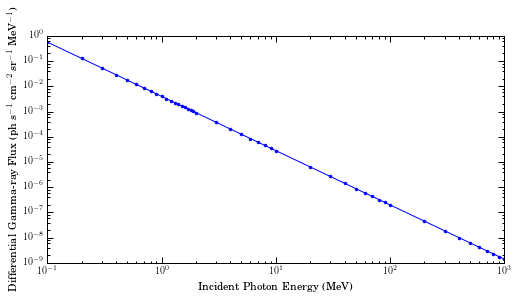

In [22]:
##########################################################################################
# Calculate the differential Gamma-ray flux spectrum
Energies_MeV = InputEnergies/1000.
ETFlux = 40.*10**(-4)*(Energies_MeV**(-2.15))

figF, axF = plt.subplots(1,1)

plt.loglog(Energies_MeV,ETFlux, 'b.-')

# Figure Properties
axF.set_ylabel(r'Differential Gamma-ray Flux (ph s$^{-1}$ cm$^{-2}$ sr$^{-1}$ MeV$^{-1}$)')  
axF.set_xlabel('Incident Photon Energy (MeV)') 
# axF.set_ylim(10**-9, 10**-2)
# axF.set_xlim(1, 1000)

# Tight Layout
plt.tight_layout()

# Save the figure 
file_figF = 'Gamma_Flux.pdf'
plt.savefig(DataFolder + file_figF, bbox_inches="tight")
print 'Plot saved to: ' + (DataFolder+file_figF)

# Show the figure
plt.show(figF)

Plot saved to: ../G4AdEPTCubeSat_Results/Ar+CS2/Gammas_3atm/Differential_Count_Rate.pdf


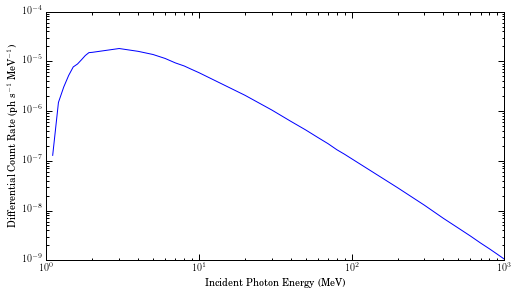

Plot saved to: ../G4AdEPTCubeSat_Results/Ar+CS2/Gammas_3atm/Integral_Count_Rate.pdf


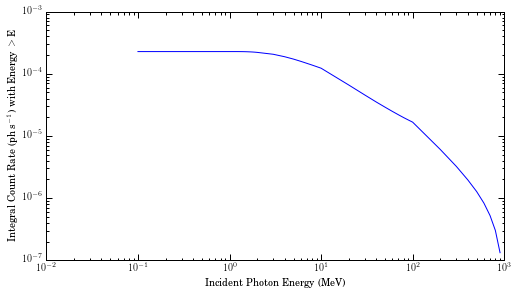

Predicted count rate of 1.26544702482 +/-  0.0243230817133 counts/orbit by Average Energy Method.
Predicted count rate of 1.07265575525  +/-  0.0205347882422 counts/orbit by Modified Simpson's Rule.
Predicted count rate of 7180.24432482  +/-  138.011047486 counts/year by Average Energy Method.
Predicted count rate of 6086.33174522  +/-  116.515977236 counts/year by Modified Simpson's Rule.


In [43]:
##########################################################################################
# Compute the Differential and Integral Count Rates

diffCountRate = G_Pair*ETFlux  # Differential count rate
intCountRate_trial = simps(diffCountRate)    # Simple Simpson's rule for calculating integral count rate

###################
# Simspn's/trapezoidal

Counts = 0
dE = 0
intCountRate_trial_2 = np.array([])

for i in range(0,len(InputEnergies)-1):    # Modified Simpson's rule with variable energy spacing
    dE = Energies_MeV[i+1]-Energies_MeV[i]
    Counts = trapz(diffCountRate[i:i+2],dx=dE)# Energies_MeV[i:i+2])# # Using dE or Energies_MeV gives the same answer
    intCountRate_trial_2 = np.append(intCountRate_trial_2,Counts)
    
intCountRate_trial2 = sum(intCountRate_trial_2)

###################
# Average energy method

def effEnergy(Energy1,Energy2):
    effEnergy1 = np.log(Energy2/Energy1)/(1./Energy1-1./Energy2)
    effEnergy2 = 1./((effEnergy1**2)*(1./Energy1-1./Energy2))
    return effEnergy1,effEnergy2    # effEnergy1 = 1./(<E>^2 * (1/E1 - 1/E2))

counts = 0
inEnergy1 = 1.*Energies_MeV[0:len(Energies_MeV)-1]
inEnergy2 = 1.*Energies_MeV[1:len(Energies_MeV)]

[effecEnergy1,effecEnergy2] = effEnergy(inEnergy1,inEnergy2)    # <E>

diffCountRate1 = diffCountRate[0:len(effecEnergy2)]/effecEnergy2
diffCountRate2 = diffCountRate[0:len(effecEnergy1)]*effecEnergy1

revDiffCountRate1 = diffCountRate1[::-1]
revDiffCountRate2 = diffCountRate2[::-1]

intCountRate1 = np.array([])
intCountRate2 = np.array([])

for i in range(0,len(diffCountRate)):
    counts = sum(revDiffCountRate1[0:i])
    intCountRate1 = np.append(intCountRate1, counts)

for i in range(0,len(diffCountRate)):
    counts = sum(revDiffCountRate2[0:i])
    intCountRate2 = np.append(intCountRate2, counts)
    
intCountRate1 = intCountRate1[::-1]
intCountRate2 = intCountRate2[::-1]

##########################################################################################
# Calculate the count rate error from Simpson's Method
low_G_Pair = G_Pair - err_G_Pair
high_G_Pair = G_Pair + err_G_Pair
diffCountRateErrorLow = low_G_Pair*ETFlux
diffCountRateErrorHigh = high_G_Pair*ETFlux

# Lowest possible counts
Counts = 0
dE = 0
intCountRateErrorLow = np.array([])

for i in range(0,len(InputEnergies)-1):    # Modified Simpson's rule with variable energy spacing
    dE = Energies_MeV[i+1]-Energies_MeV[i]
    Counts = trapz(diffCountRateErrorLow[i:i+2],dx=dE)# Energies_MeV[i:i+2])# # Using dE or Energies_MeV gives the same answer
    intCountRateErrorLow = np.append(intCountRateErrorLow,Counts)

intCountRateErrorLow = sum(intCountRateErrorLow)    
    
# Highest possible counts
Counts = 0
dE = 0
intCountRateErrorHigh = np.array([])

for i in range(0,len(InputEnergies)-1):    # Modified Simpson's rule with variable energy spacing
    dE = Energies_MeV[i+1]-Energies_MeV[i]
    Counts = trapz(diffCountRateErrorHigh[i:i+2],dx=dE)# Energies_MeV[i:i+2])# # Using dE or Energies_MeV gives the same answer
    intCountRateErrorHigh = np.append(intCountRateErrorHigh,Counts)
    
intCountRateErrorHigh = sum(intCountRateErrorHigh)

intCountRateError = (intCountRateErrorHigh-intCountRateErrorLow)/2

##########################################################################################
# Calculate the count rate error from Average Energy Method

counts = 0
inEnergy1 = 1.*Energies_MeV[0:len(Energies_MeV)-1]
inEnergy2 = 1.*Energies_MeV[1:len(Energies_MeV)]

[effecEnergy1,effecEnergy2] = effEnergy(inEnergy1,inEnergy2)    # <E>

# Lowest possible count rate
diffCountRateErrorAvgLow = diffCountRateErrorLow[0:len(effecEnergy2)]/effecEnergy2
revDiffCountRateErrorAvgLow = diffCountRateErrorAvgLow[::-1]
intCountRateErrorAvgLow = np.array([])

for i in range(0,len(diffCountRate)):
    counts = sum(revDiffCountRateErrorAvgLow[0:i])
    intCountRateErrorAvgLow = np.append(intCountRateErrorAvgLow, counts)
    
intCountRateErrorAvgLow = intCountRateErrorAvgLow[::-1]

# Highest Possible count rate
diffCountRateErrorAvgHigh = diffCountRateErrorHigh[0:len(effecEnergy2)]/effecEnergy2
revDiffCountRateErrorAvgHigh = diffCountRateErrorAvgHigh[::-1]
intCountRateErrorAvgHigh = np.array([])

for i in range(0,len(diffCountRate)):
    counts = sum(revDiffCountRateErrorAvgHigh[0:i])
    intCountRateErrorAvgHigh = np.append(intCountRateErrorAvgHigh, counts)
    
intCountRateErrorAvgHigh = intCountRateErrorAvgHigh[::-1]


intCountRateErrorAvg = (max(intCountRateErrorAvgHigh)-max(intCountRateErrorAvgLow))/2

##########################################################################################
# Plot the differential count rate
figD, axD = plt.subplots(1,1)
plt.loglog(Energies_MeV,diffCountRate,'b-')

axD.set_ylabel(r'Differential Count Rate (ph s$^{-1}$ MeV$^{-1}$)')
axD.set_xlabel('Incident Photon Energy (MeV)')
# axD.set_ylim(1e-9, 1e-4)
axD.set_xlim(1, 1000)

plt.tight_layout()

file_figD = 'Differential_Count_Rate.pdf'
plt.savefig(DataFolder + file_figD, bbox_inches="tight")
print 'Plot saved to: ' + (DataFolder+file_figD)

plt.show(figD)


##########################################################################################
# Plot the Integral Count Rate
figI, axI = plt.subplots(1,1)
plt.loglog(Energies_MeV[:len(Energies_MeV)],intCountRate1,'b-')

# Figure Properties
axI.set_ylabel(r'Integral Count Rate (ph s$^{-1}$) with Energy $>$ E')  
axI.set_xlabel('Incident Photon Energy (MeV)') 
axI.set_ylim(1e-7, 1e-3)
axI.set_xlim(1e-2, 1000)

# Tight Layout
plt.tight_layout()

# Save the figure 
file_figI = 'Integral_Count_Rate.pdf'
plt.savefig(DataFolder + file_figI, bbox_inches="tight")
print 'Plot saved to: ' + (DataFolder+file_figI)

# Show the figure
plt.show(figI)

# ##########################################################################################
# # Plot the Integral Count Rate
# print len(effecEnergy2), len(Energies_MeV)
# figInt, axInt = plt.subplots(1,1)
# plt.loglog(Energies_MeV[:len(Energies_MeV)-1],effecEnergy2,'b.-')

# # Figure Properties
# # axInt.set_ylabel(r'Integral Count Rate (ph s$^{-1}$)')  
# # axInt.set_xlabel('Incident Photon Energy (MeV)') 
# # axI.set_ylim(1e-7, 1e-3)
# # axI.set_xlim(1e-2, 1000)

# # Tight Layout
# plt.tight_layout()

# # Save the figure 
# file_figInt = 'Effective_Energy_2.pdf'
# plt.savefig(DataFolder + file_figInt, bbox_inches="tight")
# print 'Plot saved to: ' + (DataFolder+file_figInt)

# # Show the figure
# plt.show(figInt)

# ##########################################################################################
# # Plot the Integral Count Rate
# figInt2, axInt2 = plt.subplots(1,1)
# plt.loglog(Energies_MeV[:len(Energies_MeV)-1],effecEnergy1,'b.-')

# # Figure Properties
# # axI.set_ylabel(r'Integral Count Rate (ph s$^{-1}$)')  
# # axI.set_xlabel('Incident Photon Energy (MeV)') 
# # axI.set_ylim(1e-7, 1e-3)
# # axI.set_xlim(1e-2, 1000)

# # Tight Layout
# plt.tight_layout()

# # Save the figure 
# file_figInt2 = 'Effective_Energy_1.pdf'
# plt.savefig(DataFolder + file_figInt2, bbox_inches="tight")
# print 'Plot saved to: ' + (DataFolder+file_figInt2)

# # Show the figure
# plt.show(figInt2)

print "Predicted count rate of", max(intCountRate1)*60*92.6318, "+/- ", intCountRateErrorAvg*60*92.6318, "counts/orbit by Average Energy Method."
print "Predicted count rate of", intCountRate_trial2*60*92.6318," +/- ", intCountRateError*60*92.6318, "counts/orbit by Modified Simpson's Rule."
print "Predicted count rate of", max(intCountRate1)*60*60*24*365," +/- ", intCountRateErrorAvg*60*60*24*365, "counts/year by Average Energy Method."
print "Predicted count rate of", intCountRate_trial2*60*60*24*365, " +/- ", intCountRateError*60*60*24*365, "counts/year by Modified Simpson's Rule."

Plot saved to: ../G4AdEPTCubeSat_Results/Ar+CS2/Gammas_3atm/Geometric_Factor_Error_Gamma.pdf


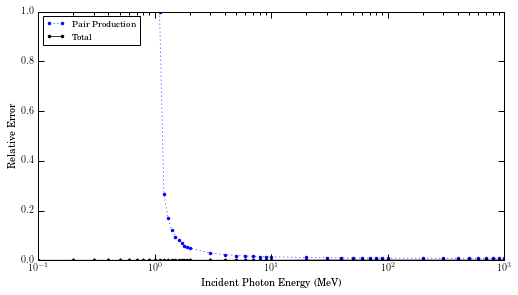

[        nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan  0.99999999  0.26726122
  0.17149856  0.12126777  0.09244998  0.08058223  0.06835852  0.0583211
  0.05150252  0.04839329  0.02865324  0.0224561   0.01900688  0.01711938
  0.01607653  0.01495338  0.01431461  0.01374218  0.01100318  0.01001353
  0.00955934  0.00916991  0.0089667   0.00877102  0.00874716  0.00856994
  0.00847551  0.00787118  0.00763783  0.00760902  0.0074854   0.00739376
  0.00737523  0.0073056   0.00728656  0.00728424]


In [46]:
##########################################################################################
# Plot the error in the Geometry Factor over a range of particle energies
figE, axE = plt.subplots(1,1)

plt.semilogx(Data[:,0]/1000., relErr_G_Pair, 'b.:', linewidth=0.75, label="Pair Production")
plt.semilogx(Data[:,0]/1000., relErr_G_Total, 'k.-', linewidth=0.75, label="Total")

# Figure Properties
axE.set_ylabel(r'Relative Error')  
axE.set_xlabel('Incident Photon Energy (MeV)') 
# axE.set_ylim(0., 0.05)
# axE.set_xlim(0.1, 1001)

axE.legend(loc='upper left')

# Tight Layout
plt.tight_layout()

# Save the figure 
file_figE = 'Geometric_Factor_Error_Gamma.pdf'
plt.savefig(DataFolder + file_figE, bbox_inches="tight")
print 'Plot saved to: ' + (DataFolder+file_figE)

# Show the figure
plt.show(figE)

Plot saved to: ../G4AdEPTCubeSat_Results/Ar+CS2/Gammas/Geometric_Factor_diffCount_Gamma.pdf


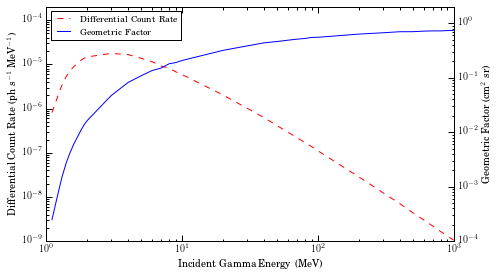

In [11]:
fig, ax1 = plt.subplots()
plot1 = ax1.loglog(Energies_MeV,diffCountRate,'r--',label='Differential Count Rate')
ax1.set_xlabel('Incident Gamma Energy (MeV)')
ax1.set_ylabel('Differential Count Rate (ph s$^{-1}$ MeV$^{-1}$)')
ax1.set_xlim(1, 1e3)
ax1.set_ylim(1e-9, 2e-4)
# ax1.legend(loc='lower right')

ax2 = ax1.twinx()
plot2 = ax2.loglog(Energies_MeV,G_Pair,'b-',label='Geometric Factor')
# ax2.loglog(Energies_MeV,G_Total,'k.-')
ax2.set_ylabel('Geometric Factor (cm$^2$ sr)')
ax2.set_xlim(1, 1e3)
ax2.set_ylim(1e-4, 2e0)
# ax2.legend(loc='lower right')

plott = plot1+plot2
labs = [l.get_label() for l in plott]
ax1.legend(plott, labs, loc='upper left')

# Save the figure 
file_fig = 'Geometric_Factor_diffCount_Gamma.pdf'
plt.savefig(DataFolder + file_fig, bbox_inches="tight")
print 'Plot saved to: ' + (DataFolder+file_fig)

plt.show()

Plot saved to: ../G4AdEPTCubeSat_Results/Ar+CS2/Gammas/Energy_Depositron_Gamma.pdf


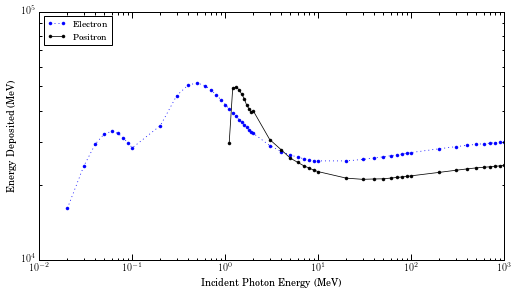

In [12]:
##########################################################################################
# Plot the electron and positron energy deposition
figE, axE = plt.subplots(1,1)

# electronEnergy_1 = Data[0:19,12]/N_R
# positronEnergy_1 = Data[0:19,11]/N_R

# electronEnergy_2 = Data[19:28,12]/N_R_2
# positronEnergy_2 = Data[19:28,11]/N_R_2

# electronEnergy_3 = Data[28:,12]/N_R
# positronEnergy_3 = Data[28:,11]/N_R

electronEnergy_1 = Data[0:19,12]/Data[0:19,2]
positronEnergy_1 = Data[0:19,11]/Data[0:19,1]

electronEnergy_2 = Data[19:28,12]/Data[19:28,2]
positronEnergy_2 = Data[19:28,11]/Data[19:28,1]

electronEnergy_3 = Data[28:,12]/Data[28:,2]
positronEnergy_3 = Data[28:,11]/Data[28:,1]

electronEnergy = np.ndarray([])
electronEnergy_temp = np.ndarray([])
electronEnergy_temp = np.append(electronEnergy_1,electronEnergy_2)
electronEnergy = np.append(electronEnergy_temp,electronEnergy_3)

positronEnergy = np.ndarray([])
positronEnergy_temp = np.ndarray([])
positronEnergy_temp = np.append(positronEnergy_1,positronEnergy_2)
positronEnergy = np.append(positronEnergy_temp,positronEnergy_3)

# electronEnergy = Data[:,12]/1000000./Data[:,4]

plt.loglog(Data[:,0]/1000., electronEnergy, 'b.:', linewidth=0.75, label="Electron")
plt.loglog(Data[:,0]/1000., positronEnergy, 'k.-', linewidth=0.75, label="Positron")

# Figure Properties
axE.set_ylabel(r'Energy Deposited (MeV)')  
axE.set_xlabel('Incident Photon Energy (MeV)') 
# axE.set_ylim(0., 0.05)
# axE.set_xlim(0.1, 1001)

axE.legend(loc='upper left')

# Tight Layout
plt.tight_layout()

# Save the figure 
file_figE = 'Energy_Depositron_Gamma.pdf'
plt.savefig(DataFolder + file_figE, bbox_inches="tight")
print 'Plot saved to: ' + (DataFolder+file_figE)

# Show the figure
# plt.show(figE)